# Replicate figure 4b from Nature Methods, Li etc. al. 

Here I attempt to replicate figure 4b from the below paper.  

https://www.nature.com/articles/s41592-022-01652-7?utm_source=twitter&utm_medium=social&utm_campaign=nmeth

I did not run their neural network (RLN), but simply ran a non-circulant classical Richardson Lucy with theoretical PSF assuming slight spherical aberration and compared it to the figure they provided


## Create a decon conda environment

In this environment we will install some tools we need for decon, this includes Jupyter noteook, opencl, fftw, clij2fft for non-circulant Richardson Lucy, devbio version of Napari for visualization, sdeconv for theoretical PSF, tnia-python XYZ projected figures in the notebook. 

    conda create --name decon-env python=3.9
    conda activate decon-env
    conda install -c conda-forge jupyterlab
    conda install -c conda-forge pyopencl==2021.2.6 hdbscan numba=0.55.1
    pip install devbio-napari
    conda install -c conda-forge fftw
    pip install napari-sdeconv
    pip install git+https://github.com/True-North-Intelligent-Algorithms/tnia-python
    pip install --index-url https://test.pypi.org/simple/ --no-deps clij2-fft

Mac-users please also install this:

    conda install -c conda-forge ocl_icd_wrapper_apple

Linux users please also install this:

    conda install -c conda-forge ocl-icd-system


## Open test images

1.  Get images from here https://www.nature.com/articles/s41592-022-01652-7?utm_source=twitter&utm_medium=social&utm_campaign=nmeth#data-availability

2.  If trying to run this notebook on your own machine obviously change the paths to where you put the figures

(61, 1024, 1024)


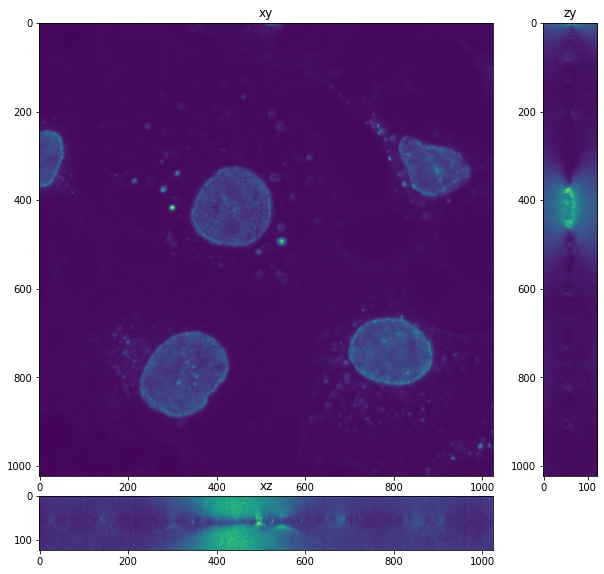

In [1]:
from skimage.io import imread
from tnia.plotting.projections import show_xyz_max, show_xyz_slice, show_xyz_slice_center, show_xyz_max
import numpy as np

im_path=r"D:\images\tnia-python-images\deconvolution\deep-learning\Figure4b\Figure4_training&test\test dataset\\"
rln_path=r"D:\images\tnia-python-images\deconvolution\deep-learning\Figure4b\Figure4_training&test\RLN_output\\"

im_name='NPC-1.tif'
rln_name='RLN_NPC-1.tif'

im=imread(im_path+im_name)
rln=imread(rln_path+rln_name)
rln=np.squeeze(rln)

im=im.astype('float32')
print(im.shape)

fig=show_xyz_slice_center(im,1,2)

## Define an ROI to work with

We try to use the same ROI as in the paper (also define a second ROI which allows us to test quickly with a very small particle)

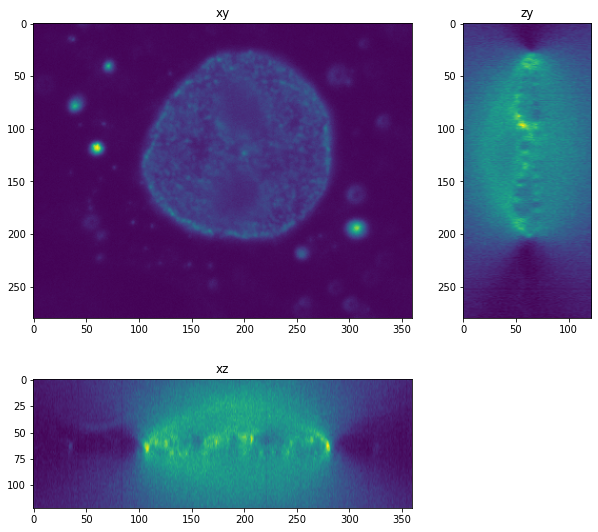

In [2]:
roi=np.s_[:, 300:580, 240:600]
#roi=np.s_[:, 390:450, 280:320]

im=im[roi]
im=np.flip(im,0)
rln=rln[roi]
rln=np.flip(rln,0)

fig=show_xyz_slice_center(im,1,2)


## Create PSF

From the paper xy voxel size is 0.101, NA 1.5, I assume a biological object with RI ~ 1.33, and calculate PSF at the center of the z range (so that the slight spherical aberration will be in the PSF). 

In [15]:
help(gibson_lanni_3D)

Help on function gibson_lanni_3D in module tnia.deconvolution.psfs:

gibson_lanni_3D(NA, ni, ns, voxel_size_xy, voxel_size_z, xy_size, z_size, pz, wvl, confocal=False)
    [summary]
    Generates and returns a Gibson Lanni PSF using the sdeconv library
    
    The function checks the version of sdeconv installed and uses the older implementation
    PSFGibsonLanni if major version is '0', or newer (PyTorch based) version if major version is '1'.



sdeconv 1.x.x detected


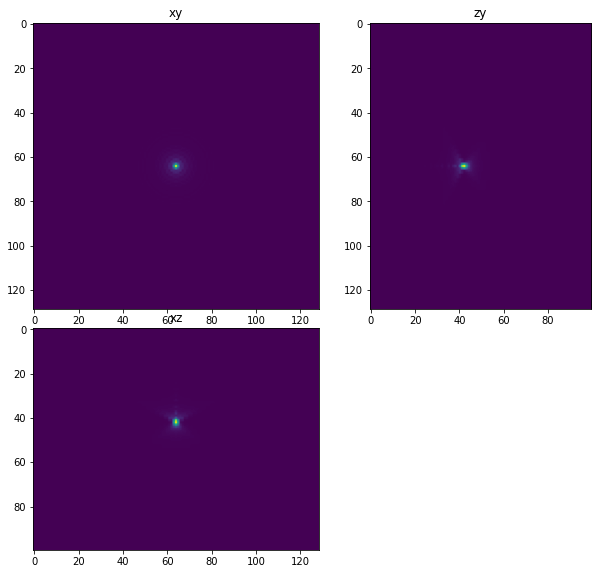

In [3]:
from tnia.deconvolution.psfs import gibson_lanni_3D

x_voxel_size = 0.101
z_voxel_size=.25

xy_psf_dim=129
z_psf_dim=100
z_d=61

NA=1.5
ni=1.5
ns=1.33

psf  = gibson_lanni_3D(NA, ni, ns, x_voxel_size, z_voxel_size, xy_psf_dim, z_psf_dim, 1.5, 0.5)
psf = psf.astype('float32')
fig = show_xyz_max(psf)

# Recenter PSF

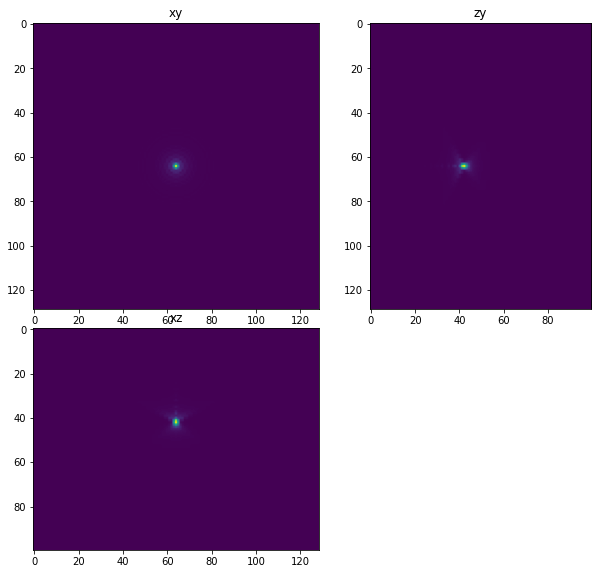

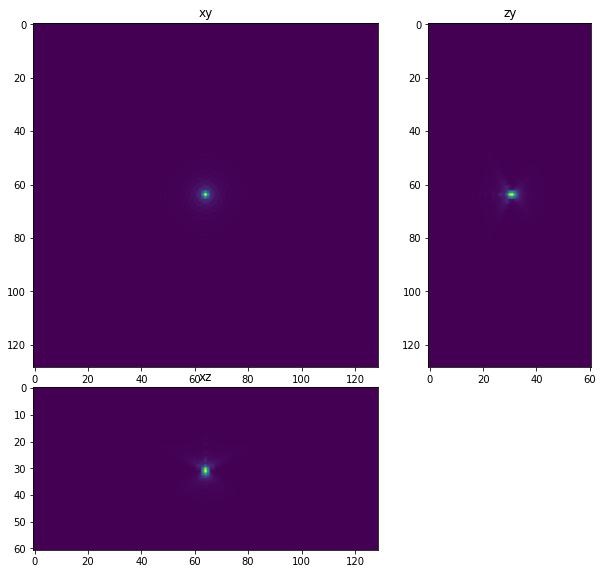

In [4]:
from tnia.deconvolution.psfs import recenter_psf_axial

fig=show_xyz_max(psf)
psf=recenter_psf_axial(psf, 61)
fig=show_xyz_max(psf)


## Deconvolve using non-circulant Richardson Lucy

In [5]:
from clij2fft.richardson_lucy import richardson_lucy_nc
regularization_factor=0
im_decon = richardson_lucy_nc(im, psf, 1000, regularization_factor)

get lib


In [12]:
help(fig)

Help on Figure in module matplotlib.figure object:

class Figure(FigureBase)
 |  Figure(figsize=None, dpi=None, facecolor=None, edgecolor=None, linewidth=0.0, frameon=None, subplotpars=None, tight_layout=None, constrained_layout=None, *, layout=None, **kwargs)
 |  
 |  The top level container for all the plot elements.
 |  
 |  The Figure instance supports callbacks through a *callbacks* attribute
 |  which is a `.CallbackRegistry` instance.  The events you can connect to
 |  are 'dpi_changed', and the callback will be called with ``func(fig)`` where
 |  fig is the `Figure` instance.
 |  
 |  Attributes
 |  ----------
 |  patch
 |      The `.Rectangle` instance representing the figure background patch.
 |  
 |  suppressComposite
 |      For multiple images, the figure will make composite images
 |      depending on the renderer option_image_nocomposite function.  If
 |      *suppressComposite* is a boolean, this will override the renderer.
 |  
 |  Method resolution order:
 |      Figu

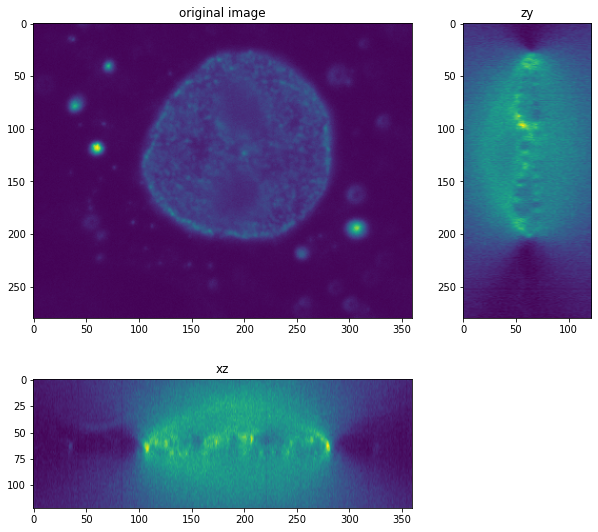

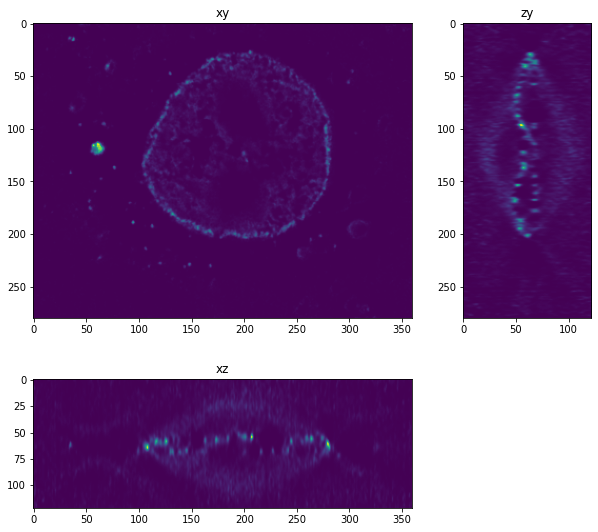

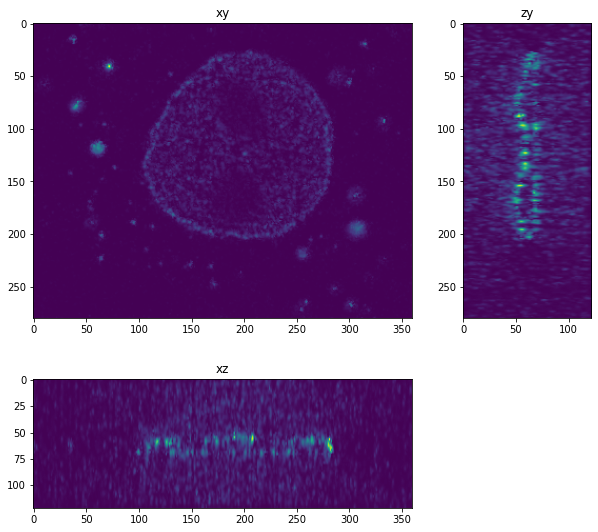

In [14]:
fig=show_xyz_slice_center(im,1,2)
fig.get_axes()[0].set_title('Original image')
fig=show_xyz_slice_center(im_decon,1,2)
fig=show_xyz_slice_center(rln,1,2)


## Visualize in Napari

In [9]:
import napari
viewer=napari.Viewer()

#viewer.add_image(im, scale=(2,1,1))
viewer.add_image(im_decon, scale=(2,1,1))
viewer.add_image(rln, scale=(2,1,1))


C:\Users\bnort\miniconda3\envs\decon-napari\lib\site-packages\napari_tools_menu\__init__.py:168: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)
ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "C:\Users\bnort\miniconda3\envs\decon-napari\lib\site-packages\zmq\eventloop\zmqstream.py", line 431, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\bnort\miniconda3\envs\decon-napari\lib\site-packages\jupyter_client\threaded.py", line 122, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "C:\Users\bnort\miniconda3\envs\decon-napari\lib\asyncio\base_events.py", line 623, in ru

<Image layer 'rln' at 0x2b521dcd4c0>